In [1]:
import numpy as np
import pandas as pd
import altair as alt
alt.data_transformers.enable('json')
alt.renderers.enable('jupyterlab')
from sublimpy import utils
import pytz
import datetime as dt

seconds_in_timestep = 60*30
from metpy.constants import density_water

from metpy.units import units
from sublimpy import extrautils
import swifter
from metpy import calc
from metpy import units

# Open SOS Measurement Dataset

In [2]:
ls -lah process_slow_data/ | grep parquet

-rw-r--r--@    1 elischwat  staff    65M Dec 19 23:09 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags360.parquet
-rw-r--r--@    1 elischwat  staff    66M Jan  3 12:55 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_archive.parquet
-rw-r--r--     1 elischwat  staff    66M Jan 10 10:35 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet
-rw-r--r--@    1 elischwat  staff    66M Jan  3 10:58 tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10_archive.parquet


In [3]:
start_date = '20221101'
end_date = '20230619'
# open files
tidy_df = pd.read_parquet(f'process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet')
# convert time column to datetime
tidy_df = utils.modify_df_timezone(tidy_df, pytz.UTC, 'US/Mountain')

tidy_df = tidy_df[tidy_df.time < '20230509']
tidy_df = tidy_df[tidy_df.time > '20221130']

In [4]:
tidy_df.time.min(), tidy_df.time.max()

(Timestamp('2022-11-30 00:30:00'), Timestamp('2023-05-08 23:30:00'))

# Create streamwise dataset

In [5]:
# # slow method
# # tidy_df_streamwise = extrautils.streamwise_coordinates_single_rotation_tidy_df(tidy_df)
# # fast method
# tidy_df_streamwise = tidy_df.swifter.groupby('time').apply(extrautils.streamwise_coordinates_single_rotation_tidy_df)
# tidy_df_streamwise = tidy_df_streamwise.reset_index(drop=True)  

# Identify categories

In [6]:
# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0.01").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0.01").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 92").time.values
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 342").query("value > 292").time.values

(-100.0, 100.0)

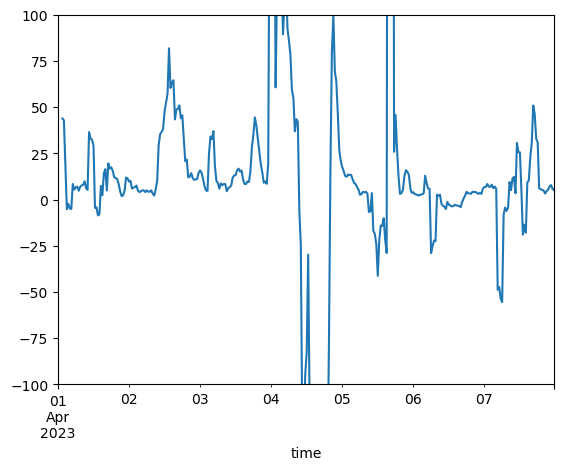

In [7]:
src = tidy_df[tidy_df.variable.isin(['u*_3m_c', 'Tsurfvirtual_c', 'Tvirtual_1m_c', 'Tvirtual_2m_c', 'Tvirtual_3m_c','w_tc__3m_c',])].pivot_table(index='time', columns='variable', values='value')
src['Tvirtual_avg'] = src[['Tsurfvirtual_c', 'Tvirtual_3m_c']].mean(axis=1)
l_3m_c = - (src['u*_3m_c']**3)*(src['Tvirtual_avg']+273.15) / (0.4 * 9.81 * src['w_tc__3m_c'])
# tidy_df[tidy_df.variable == 'L_3m_c'].set_index('time').loc['20230201': '20230207'].value.plot()
l_3m_c.loc['20230401': '20230407'].rolling(4).mean().plot()
import matplotlib.pyplot as plt
plt.ylim(-100,100)

In [8]:
z_over_L_3m_c = 3 / l_3m_c

In [9]:
z_over_L_stable_times = z_over_L_3m_c[z_over_L_3m_c > 0.1].index
z_over_L_neutral_times = z_over_L_3m_c[(z_over_L_3m_c <= 0.1) & (z_over_L_3m_c >= -0.1)].index
z_over_L_unstable_times = z_over_L_3m_c[z_over_L_3m_c < -0.1].index

In [10]:
print(len(z_over_L_stable_times), len(tgrad_stable_times))
print(len(z_over_L_neutral_times), len(tgrad_neutral_times))
print(len(z_over_L_unstable_times), len(tgrad_unstable_times))

3066 7013
2826 415
1106 229


In [11]:
w_h2o__vars = [
    'w_h2o__3m_d',
    'w_h2o__10m_d',
    'w_h2o__3m_uw',
    'w_h2o__10m_uw',
    'w_h2o__3m_ue',
    'w_h2o__10m_ue',
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
]

w_tc__vars = [
    'w_tc__3m_d',
    'w_tc__10m_d',
    'w_tc__3m_uw',
    'w_tc__10m_uw',
    'w_tc__3m_ue',
    'w_tc__10m_ue',
    'w_tc__2m_c',
    'w_tc__3m_c',
    'w_tc__5m_c',
    'w_tc__10m_c',
    'w_tc__15m_c',
    'w_tc__20m_c',
]

# Create datasets for each turbulence variable

We first create a dataset with w_h2o_ measurements. We filter out any timestamps with any NaNs, which may be introduced by our data cleaning process. We also make sure that each measurement height has the same number of data points, by removing data points where some measurements had nan but others did not.

We can then use these timestamps to filter other turbulence variable

In [12]:
w_h2o__measurements_df = tidy_df[tidy_df.variable.isin(w_h2o__vars)]
src = w_h2o__measurements_df.pivot(index='time', columns='variable', values='value').dropna().melt(ignore_index=False)

from sublimpy import tidy

src['height'] = src.variable.apply(tidy._height_from_variable_name)
src['tower'] = src.variable.apply(tidy._tower_from_variable_name)
w_h2o__measurements_df = src.reset_index()

In [13]:
timestamps_to_use = w_h2o__measurements_df.time.unique()

In [14]:
# ustar_measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement == 'shear velocity']
# ustar_measurements_df = ustar_measurements_df[ustar_measurements_df.time.isin(timestamps_to_use)]
# w_tc__measurements_df = tidy_df_streamwise[tidy_df_streamwise.variable.isin(w_tc__vars)]
# w_tc__measurements_df = w_tc__measurements_df[w_tc__measurements_df.time.isin(timestamps_to_use)]
# u_h2o__measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement == 'u_h2o_']
# u_h2o__measurements_df = u_h2o__measurements_df[u_h2o__measurements_df.time.isin(timestamps_to_use)]
# v_h2o__measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement == 'v_h2o_']
# v_h2o__measurements_df = v_h2o__measurements_df[v_h2o__measurements_df.time.isin(timestamps_to_use)]
# u_w__measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement == 'u_w_']
# u_w__measurements_df = u_w__measurements_df[u_w__measurements_df.time.isin(timestamps_to_use)]
# v_w__measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement == 'v_w_']
# v_w__measurements_df = v_w__measurements_df[v_w__measurements_df.time.isin(timestamps_to_use)]

# w_measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement == 'w']
# w_measurements_df = w_measurements_df[w_measurements_df.time.isin(timestamps_to_use)]
# u_measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement == 'u']
# u_measurements_df = u_measurements_df[u_measurements_df.time.isin(timestamps_to_use)]
# v_measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement == 'v']
# v_measurements_df = v_measurements_df[v_measurements_df.time.isin(timestamps_to_use)]
# q_measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement == 'specific humidity']
# q_measurements_df = q_measurements_df[q_measurements_df.time.isin(timestamps_to_use)]
# tke_measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement  == 'turbulent kinetic energy']
# tke_measurements_df = tke_measurements_df[tke_measurements_df.time.isin(timestamps_to_use)]
# w_w__measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement  == 'w_w_']
# w_w__measurements_df = w_w__measurements_df[w_w__measurements_df.time.isin(timestamps_to_use)]

# spd_measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement  == 'wind speed']
# spd_measurements_df = spd_measurements_df[spd_measurements_df.time.isin(timestamps_to_use)]

# dir_measurements_df = tidy_df_streamwise[tidy_df_streamwise.measurement  == 'wind direction']
# dir_measurements_df = dir_measurements_df[dir_measurements_df.time.isin(timestamps_to_use)]

# Define functions for plotting profiles

In [15]:
def profile_chart(df, title, x_title):
    return (
        alt.Chart(df).mark_line().encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True).title("Height (m)"),
            alt.Color("tower:N")
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=100, height=100)
    )

def lhflux_profile_chart(df, title):
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title("Height (m)"),
            alt.Color("tower:N")
        )
        +
        alt.Chart(df).mark_line().encode(
            alt.X("median(value):Q").sort('-y').title("<w'q'> (g/m^2/s)"),
            alt.Y("height:Q").scale(zero=True).title("Height (m)"),
            alt.Color("tower:N")
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

def lhflux_profile_chart_split_conditions(df, title, x_title="<w'q'> (g/m^2/s)", color_encoding=alt.Color(f"conditions:N")):
    n_bs = len(df[df.conditions == 'BS'].time.unique())
    n_nobs = len(df[df.conditions == 'No BS'].time.unique())
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower', 'conditions']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title('Height (m)'),
            color_encoding
        )
        +
        alt.Chart(df).mark_line(point=True).encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True),
            color_encoding
        ).properties(
            title=[
                title, 
                # f"(n = {n_bs} BS, {n_nobs} No BS)"
                   ], 
            width=150, 
            height=150
        )
    )

def lhflux_profile_chart_split_conditions_noerror(df, title, x_title="<w'q'> (g/m^2/s)", color_encoding=alt.Color(f"conditions:N")):
    n_bs = len(df[df.conditions == 'BS'].time.unique())
    n_nobs = len(df[df.conditions == 'No BS'].time.unique())
    return alt.Chart(df).mark_line(point=True).encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True),
            color_encoding
        ).properties(title=[title, f"(n = {n_bs} BS, {n_nobs} No BS)"], width=150, height=150)

def lhflux_profile_chart_notower(df, title, x_title="<w'q'> (g/m^2/s)"):
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.2, color='black').encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").title('Height(m)').scale(zero=True),
        )
        +
        alt.Chart(df).mark_line(point=alt.OverlayMarkDef(color='black'), color='black').encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True),
        ).properties(title=title, width=150, height=150)
    )

def lhflux_profile_chart_mg(df, title):
    df.value = df.value*1000
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title("Height (m)"),
            alt.Color("tower:N")
        )
        +
        alt.Chart(df).mark_line(point=True).encode(
            alt.X("median(value):Q").sort('-y').title("<w'q'> (mg/m^2/s)"),
            alt.Y("height:Q").scale(zero=True).title("Height (m)"),
            alt.Color("tower:N")
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

def profile_chart(df, title, x_title, color="tower:N"):
    return (
        alt.Chart(df).transform_aggregate(
            median = "median(value)",
            groupby=['height', 'tower']
        ).transform_calculate(
            low_bound = 'datum.median - 0.2*datum.median',
            up_bound = 'datum.median + 0.2*datum.median'
        ).mark_area(opacity=0.25).encode(
            alt.X("low_bound:Q").title(""),
            alt.X2("up_bound:Q"),
            alt.Y("height:Q").scale(zero=True).title("Height (m)"),
            alt.Color("tower:N")
        )
        +
        alt.Chart(df).mark_line().encode(
            alt.X("median(value):Q").sort('-y').title(x_title),
            alt.Y("height:Q").scale(zero=True).title("Height (m)"),
            alt.Color(color)
        ).properties(title=[title, f"(n = {len(df.time.unique())})"], width=150, height=150)
    )

## Define function to categorize profiles as we like

In [16]:
from astral import LocationInfo
from suntime import Sun
from zoneinfo import ZoneInfo

# On a special date in your machine's local time zone
sun = Sun(38.957984, -106.988687)
def assign_bs_and_daytime_label(this_time):
    label = ''
    utc_aware = this_time.replace(tzinfo=ZoneInfo('US/Mountain'))  # make aware
    sunrise = sun.get_sunrise_time(this_time, time_zone=pytz.timezone('US/Mountain')).replace(tzinfo=None)
    sunset = sun.get_sunset_time(this_time, time_zone=pytz.timezone('US/Mountain')).replace(tzinfo=None)
    if sunrise > sunset:
        sunset = sunset + dt.timedelta(days=1)
    
    if this_time in bs_times:
        label += 'BS'
    else:
        label += 'No BS'
    if (this_time > sunrise) & (this_time < sunset):
        label += ', Daytime'
    else:
        label += ', Nighttime'
    if label.startswith('BS'):
        label = 'BS'
    return label


# Plot for publication

In [21]:
tgrad_stable_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(tgrad_stable_times))]
tgrad_neutral_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(tgrad_neutral_times))]
tgrad_unstable_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(tgrad_unstable_times))]

tgrad_stable_df = tgrad_stable_df.assign(conditions = tgrad_stable_df.time.apply(assign_bs_and_daytime_label))
tgrad_neutral_df = tgrad_neutral_df.assign(conditions = tgrad_neutral_df.time.apply(assign_bs_and_daytime_label))
tgrad_unstable_df = tgrad_unstable_df.assign(conditions = tgrad_unstable_df.time.apply(assign_bs_and_daytime_label))

n_alldata = len(w_h2o__measurements_df.query("tower == 'c'").query("height == 10").dropna())
n_stable = tgrad_stable_df.query("tower == 'c'").query("height == 10").dropna().groupby('conditions').apply(len)
n_neutral = tgrad_neutral_df.query("tower == 'c'").query("height == 10").dropna().groupby('conditions').apply(len)
n_unstable = tgrad_unstable_df.query("tower == 'c'").query("height == 10").dropna().groupby('conditions').apply(len)

print(n_alldata)
print(n_stable)
print(n_neutral)
print(n_unstable)

5999
conditions
BS                   785
No BS, Daytime      2044
No BS, Nighttime    2654
dtype: int64
conditions
BS                   73
No BS, Daytime      234
No BS, Nighttime     25
dtype: int64
conditions
BS                 15
No BS, Daytime    169
dtype: int64


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_86319/1842824537.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_stable = tgrad_stable_df.query("tower == 'c'").query("height == 10").dropna().groupby('conditions').apply(len)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_86319/1842824537.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_neutral = tgrad_neutral_df.query("tow

In [22]:
vertical_flux_profiles_4_plots = (
    lhflux_profile_chart_notower(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(tgrad_stable_df.query("tower == 'c'").query("height > 1"), "Stable") |
    lhflux_profile_chart_split_conditions(tgrad_neutral_df.query("tower == 'c'").query("height > 1"), "Neutral") |
    lhflux_profile_chart_split_conditions(tgrad_unstable_df.query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


Try the same thing but using z/L

In [17]:
z_over_L_stable_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(z_over_L_stable_times))]
z_over_L_neutral_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(z_over_L_neutral_times))]
z_over_L_unstable_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(z_over_L_unstable_times))]

z_over_L_stable_df = z_over_L_stable_df.assign(conditions = z_over_L_stable_df.time.apply(assign_bs_and_daytime_label))
z_over_L_neutral_df = z_over_L_neutral_df.assign(conditions = z_over_L_neutral_df.time.apply(assign_bs_and_daytime_label))
z_over_L_unstable_df = z_over_L_unstable_df.assign(conditions = z_over_L_unstable_df.time.apply(assign_bs_and_daytime_label))

n_alldata = len(w_h2o__measurements_df.query("tower == 'c'").query("height == 10").dropna())
n_stable = z_over_L_stable_df.query("tower == 'c'").query("height == 10").dropna().groupby('conditions').apply(len)
n_neutral = z_over_L_neutral_df.query("tower == 'c'").query("height == 10").dropna().groupby('conditions').apply(len)
n_unstable = z_over_L_unstable_df.query("tower == 'c'").query("height == 10").dropna().groupby('conditions').apply(len)

print(n_alldata)
print(n_stable)
print(n_neutral)
print(n_unstable)

5999
conditions
BS                   158
No BS, Daytime      1025
No BS, Nighttime    1409
dtype: int64
conditions
BS                  711
No BS, Daytime      952
No BS, Nighttime    851
dtype: int64
conditions
BS                    4
No BS, Daytime      470
No BS, Nighttime    419
dtype: int64


/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_86319/1364788224.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_stable = z_over_L_stable_df.query("tower == 'c'").query("height == 10").dropna().groupby('conditions').apply(len)
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_86319/1364788224.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  n_neutral = z_over_L_neutral_df.quer

In [19]:
vertical_flux_profiles_4_plots = (
    lhflux_profile_chart_notower(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(z_over_L_stable_df.query("tower == 'c'").query("height > 1"), "Stable") |
    lhflux_profile_chart_split_conditions(z_over_L_neutral_df.query("tower == 'c'").query("height > 1"), "Neutral") |
    lhflux_profile_chart_split_conditions(z_over_L_unstable_df.query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [ ]:
def plot_for_turb_variables(
        variable_src_df,
        x_title="<w't'> (K/m^2/s)",
        daytime_only = False
):
    tgrad_stable_df = variable_src_df[variable_src_df.time.isin(set(tgrad_stable_times))]
    tgrad_neutral_df = variable_src_df[variable_src_df.time.isin(set(tgrad_neutral_times))]
    tgrad_unstable_df = variable_src_df[variable_src_df.time.isin(set(tgrad_unstable_times))]

    variable_src_df = variable_src_df.assign(conditions = variable_src_df.time.apply(assign_bs_and_daytime_label))
    tgrad_stable_df = tgrad_stable_df.assign(conditions = tgrad_stable_df.time.apply(assign_bs_and_daytime_label))
    tgrad_neutral_df = tgrad_neutral_df.assign(conditions = tgrad_neutral_df.time.apply(assign_bs_and_daytime_label))
    tgrad_unstable_df = tgrad_unstable_df.assign(conditions = tgrad_unstable_df.time.apply(assign_bs_and_daytime_label))
    if daytime_only:
        variable_src_df = variable_src_df.query("conditions == 'No BS, Daytime'")
        tgrad_stable_df = tgrad_stable_df.query("conditions == 'No BS, Daytime'")
        tgrad_neutral_df = tgrad_neutral_df.query("conditions == 'No BS, Daytime'")
        tgrad_unstable_df = tgrad_unstable_df.query("conditions == 'No BS, Daytime'")
    color_encoding_nobs = alt.Color(f"conditions:N").scale(domain=['No BS, Daytime', 'No BS, Nighttime'], range=['#ff7f0e', '#d62728'])
    return (
        lhflux_profile_chart_notower(variable_src_df.query("conditions != 'BS'").query("tower == 'c'").query("height > 1"), "All data", x_title=x_title)
        |
        lhflux_profile_chart_split_conditions(
            tgrad_stable_df.query("conditions != 'BS'").query("tower == 'c'").query("height > 1"), "Stable", x_title=x_title,
            color_encoding = color_encoding_nobs
        )
        |
        lhflux_profile_chart_split_conditions(
            tgrad_neutral_df.query("conditions != 'BS'").query("tower == 'c'").query("height > 1"), "Neutral", x_title=x_title,
            color_encoding = color_encoding_nobs
        )
        |
        lhflux_profile_chart_split_conditions(
            tgrad_unstable_df.query("conditions != 'BS'").query("tower == 'c'").query("height > 1"), "Unstable", x_title=x_title,
            color_encoding = color_encoding_nobs
        )
    ).resolve_scale(x='shared', y='shared') 

# Calculate scaled turbulence variables

### $ \sqrt{w'w'} / u_*$

In [ ]:
x = None
# extra logic here to remove variables that have None as their tower...stupid
tower = tidy_df_streamwise[~tidy_df_streamwise.variable.str.endswith('_raw')].tower.unique()
w_w_scaled_df = pd.DataFrame()
for t in tower:
    src_many_heights = tidy_df_streamwise[tidy_df_streamwise.measurement.isin(['w_w_', 'shear velocity'])]
    src_many_heights = src_many_heights[src_many_heights.tower == t]
    if t == 'c':
        heights = [2,3,5,10,15,20]
    else:
        heights = [3,10]
    for h in heights:
        src = src_many_heights[src_many_heights.height == h]
        src = src.pivot_table(index='time', columns='measurement', values='value')
        src['w_w_scaled'] = src['w_w_']**0.5 / src['shear velocity']
        src = src[['w_w_scaled']].reset_index().melt(id_vars='time')
        src['variable'] = src['measurement'].apply(lambda meas: f"{meas}_{h}m_{t}")
        src['height'] = h
        src['tower'] = t
        w_w_scaled_df = pd.concat([w_w_scaled_df, src])

### $ \sqrt{tke} / u_*$

In [ ]:
x = None
# extra logic here to remove variables that have None as their tower...stupid
tower = tidy_df_streamwise[~tidy_df_streamwise.variable.str.endswith('_raw')].tower.unique()
tke_scaled_df = pd.DataFrame()
for t in tower:
    src_many_heights = tidy_df_streamwise[tidy_df_streamwise.measurement.isin(['turbulent kinetic energy', 'shear velocity'])]
    src_many_heights = src_many_heights[src_many_heights.tower == t]
    if t == 'c':
        heights = [2,3,5,10,15,20]
    else:
        heights = [3,10]
    for h in heights:
        src = src_many_heights[src_many_heights.height == h]
        src = src.pivot_table(index='time', columns='measurement', values='value')
        src['tke_scaled'] = src['turbulent kinetic energy']**0.5 / src['shear velocity']
        src = src[['tke_scaled']].reset_index().melt(id_vars='time')
        src['variable'] = src['measurement'].apply(lambda meas: f"{meas}_{h}m_{t}")
        src['height'] = h
        src['tower'] = t
        tke_scaled_df = pd.concat([tke_scaled_df, src])

# Plot extra turbulence variables

In [ ]:
(
    plot_for_turb_variables(u_h2o__measurements_df,     "u'q' (g/m^2/s)" ,  daytime_only=True) &\
    plot_for_turb_variables(v_h2o__measurements_df,     "v'q' (g/m^2/s)" ,  daytime_only=True)
).resolve_scale(x='shared', y='shared')

In [ ]:
plot_for_turb_variables(w_tc__measurements_df,      "<w't'> (K/m^2/s)", daytime_only=True)

In [ ]:
plot_for_turb_variables(ustar_measurements_df,      "u* (m/s)"       ,  daytime_only=True)

In [ ]:
(
    plot_for_turb_variables(u_w__measurements_df,       "u'w' (m^2/s^2)" ,  daytime_only=True) &
    plot_for_turb_variables(v_w__measurements_df,       "v'w' (m^2/s^2)" ,  daytime_only=True)
).resolve_scale(x='shared', y='shared')

In [ ]:
(   
    plot_for_turb_variables(tke_measurements_df,        "tke (m^2/s^2)" ,   daytime_only=True) &\
    plot_for_turb_variables(w_w_scaled_df,              "(<w'w'>)^0.5 / u*",daytime_only=True)
).resolve_scale(x='shared', y='shared')

In [ ]:
(
    plot_for_turb_variables(tke_scaled_df,              "(tke)^0.5 / u*",   daytime_only=True) &
    plot_for_turb_variables(spd_measurements_df,        "wind speed (m/s)", daytime_only=True) &
    plot_for_turb_variables(dir_measurements_df,        "wind direction (˚)", daytime_only=True)
).resolve_scale( y='shared')

# EXTRA STUFF

# Calculate frequency of lh flux divergence 

Use two different thresholds, 10% and 30%

We compare measurements at 2 measurement heights at a time (2 and 3, and 3 and 5). This is not comprehensive.

In [ ]:
src = w_h2o__measurements_df.pivot(index='time', columns='variable', values='value')
src_w = w_measurements_df.pivot(index='time', columns='variable', values='value')

## Using 2 and 3 meter measurements and 3 and 5 meter measurements

In [ ]:
src['percent diff 2 3'] = (src['w_h2o__3m_c'] - src['w_h2o__2m_c']) / src[['w_h2o__3m_c', 'w_h2o__2m_c']].mean(axis=1)
src['percent diff 3 5'] = (src['w_h2o__5m_c'] - src['w_h2o__3m_c']) / src[['w_h2o__5m_c', 'w_h2o__3m_c']].mean(axis=1)

percent_gt_10_2_3 = len(src[src["percent diff 2 3"] > 0.1])/len(src)
percent_gt_10_3_5 = len(src[src["percent diff 3 5"] > 0.1])/len(src)
percent_gt_30_2_3 = len(src[src["percent diff 2 3"] > 0.3])/len(src)
percent_gt_30_3_5 = len(src[src["percent diff 3 5"] > 0.3])/len(src)

print(f"Using 2 and 3m ECs, LH flux diverges more than 10%, {round(percent_gt_10_2_3*100, 1)}% of the time")
print(f"Using 3 and 5m ECs, LH flux diverges more than 10%, {round(percent_gt_10_3_5*100, 1)}% of the time")
print(f"Using 2 and 3m ECs, LH flux diverges more than 30%, {round(percent_gt_30_2_3*100, 1)}% of the time")
print(f"Using 3 and 5m ECs, LH flux diverges more than 30%, {round(percent_gt_30_3_5*100, 1)}% of the time")

In [ ]:
for name, times in [
    ("bs_times", bs_times,),
    ("nobs_times", nobs_times,),
    ("decoupled_times", decoupled_times,),
    ("weaklycoupled_times", weaklycoupled_times,),
    ("coupled_times", coupled_times,),
    ("ri_stable_times", ri_stable_times,),
    ("ri_unstable_times", ri_unstable_times,),
    ("ri_neutral_times", ri_neutral_times,),
    ("tgrad_stable_times", tgrad_stable_times,),
    ("tgrad_unstable_times", tgrad_unstable_times,),
    ("tgrad_neutral_times", tgrad_neutral_times),
]:
    local_src = src.reset_index()
    local_src = local_src[local_src.time.isin(times)]
    percent_gt_10_2_3 = len(local_src[local_src["percent diff 2 3"] > 0.1])/len(local_src)
    percent_gt_10_3_5 = len(local_src[local_src["percent diff 3 5"] > 0.1])/len(local_src)
    percent_gt_30_2_3 = len(local_src[local_src["percent diff 2 3"] > 0.3])/len(local_src)
    percent_gt_30_3_5 = len(local_src[local_src["percent diff 3 5"] > 0.3])/len(local_src)
    print(name)
    print(f"Using 2 and 3m ECs, LH flux diverges more than 10%, {round(percent_gt_10_2_3*100, 1)}% of the time")
    print(f"Using 3 and 5m ECs, LH flux diverges more than 10%, {round(percent_gt_10_3_5*100, 1)}% of the time")
    print(f"Using 2 and 3m ECs, LH flux diverges more than 30%, {round(percent_gt_30_2_3*100, 1)}% of the time")
    print(f"Using 3 and 5m ECs, LH flux diverges more than 30%, {round(percent_gt_30_3_5*100, 1)}% of the time")
    print()

In [ ]:
for T in [-20, -10, 0, 5]:
    print(f"T: {T}")
    for rh in [50.0, 50-1.5, 50+1.5]:
        s = 1000*calc.mixing_ratio_from_relative_humidity(
            0.7   *   units.units('atm'),
            T  *   units.units('degC'),
            rh  *   units.units('percent')
        )
        print(f"RH: {rh}%,\ts: {round(s,2)}, σ: ± ")

In [ ]:
src = tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'")
src = src[src.time.isin(nobs_times)]
src = src[src.time.isin(upvalley_wind_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
(alt.Chart(src[src.conditions < 12]).transform_filter(
    alt.datum.height > 0
).mark_line().encode(
    alt.X('mean(value):Q').scale(zero=False),
    alt.Y('height:Q'),
    alt.Color('hours(time):N')
).properties(width=150, height=150) | alt.Chart(src[src.conditions > 12]).transform_filter(
    alt.datum.height > 0
).mark_line().encode(
    alt.X('mean(value):Q').scale(zero=False),
    alt.Y('height:Q'),
    alt.Color('hours(time):N')
).properties(width=150, height=150)).resolve_scale(color='independent').display(renderer='svg')

In [ ]:
src = tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'")
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src_downvalley = src[src.time.isin(downvalley_wind_times)]
src_upvalley = src[src.time.isin(upvalley_wind_times)]
def plot(src):
    return (alt.Chart(src[src.conditions < 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('mean(value):Q').scale(zero=False).title('Mixing ratio (g/g)'),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150) | alt.Chart(src[src.conditions > 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('mean(value):Q').scale(zero=False).title('Mixing ratio (g/g)'),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150)).resolve_scale(x='shared', color='independent')
(plot(src_downvalley).properties(title='Downvalley winds') & plot(src_upvalley).properties(title='Upvalley winds') & plot(src).properties(title='Neither')).resolve_scale(
    x='shared', 
    # color='shared'
) 

In [ ]:
rule = alt.Chart().transform_calculate(rule='0').mark_rule().encode(x='rule:Q')

In [ ]:
src = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").query("height >= 3")
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src_downvalley = src[src.time.isin(downvalley_wind_times)]
src_upvalley = src[src.time.isin(upvalley_wind_times)]
def plot(src):
    return (alt.Chart(src[src.conditions < 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('median(value):Q').scale(zero=False).title('w (m/s)'),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150) + rule | rule+alt.Chart(src[src.conditions > 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('median(value):Q').scale(zero=False).title('w (m/s)'),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150)).resolve_scale(x='shared', color='independent')
(plot(src_downvalley).properties(title='Downvalley winds') & plot(src_upvalley).properties(title='Upvalley winds') & plot(src).properties(title='Neither')).resolve_scale(
    x='shared', 
    # color='shared'
) 

In [ ]:
src = w_h2o__measurements_df.query("tower == 'c'").query("height >= 3")
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src_downvalley = src[src.time.isin(downvalley_wind_times)]
src_upvalley = src[src.time.isin(upvalley_wind_times)]
def plot(src):
    return (alt.Chart(src[src.conditions < 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('median(value):Q').scale(zero=False).title("w'q' (g/m^2/s)"),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150) + rule | rule+alt.Chart(src[src.conditions > 12]).transform_filter(
        alt.datum.height > 0
    ).mark_line().encode(
        alt.X('median(value):Q').scale(zero=False).title("w'q' (g/m^2/s)"),
        alt.Y('height:Q'),
        alt.Color('hours(time):N')
    ).properties(width=150, height=150)).resolve_scale(x='shared', color='independent')
(plot(src_downvalley).properties(title='downvalley') & plot(src_upvalley).properties(title='upvalley') & plot(src).properties(title='Neither')).resolve_scale(
    x='shared', 
    # color='shared'
) 

In [ ]:
src = w_h2o__measurements_df.copy()
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 4 == 0]
src = src.query("tower == 'c'").query("height > 1")
def by_hour_dual_plot(src):
    return (
        lhflux_profile_chart_split_conditions(src," ").properties(title=' ', width=100, height=100)
    )
(by_hour_dual_plot(src = src[src.time.dt.month == 12]).properties(title='December') |\
by_hour_dual_plot(src = src[src.time.dt.month == 1]).properties(title='January') |\
by_hour_dual_plot(src = src[src.time.dt.month == 2]).properties(title='February') |\
by_hour_dual_plot(src = src[src.time.dt.month == 3]).properties(title='March') |\
by_hour_dual_plot(src = src[src.time.dt.month == 4]).properties(title='April') |\
by_hour_dual_plot(src = src[src.time.dt.month == 5]).properties(title='May')
).display(renderer='svg')

In [ ]:
by_hour_dual_plot(src = src[src.time.dt.strftime('%Y%m%d') == '20230505'])

In [ ]:
src = w_h2o__measurements_df.copy()
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 3 == 0]
src = src.query("tower == 'c'").query("height > 1")
(
    lhflux_profile_chart_split_conditions(
        src[src.time.dt.strftime('%Y%m%d') == '20230417']," "
    ).properties(title='20230417', width=200, height=200)
    |\
    lhflux_profile_chart_split_conditions(
        src[src.time.dt.strftime('%Y%m%d') == '20230505']," "
    ).properties(title='20230505', width=200, height=200)
).display(renderer='svg')

In [ ]:
src = u_h2o__measurements_df.copy()
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src = src.query("tower == 'c'").query("height > 1")
(
lhflux_profile_chart_split_conditions(src[src.conditions < 12],"All data") |\
lhflux_profile_chart_split_conditions(src[src.conditions >= 12],"All data")
).resolve_scale(color='independent', x='shared')

In [ ]:
src = v_h2o__measurements_df.copy()
src = src[src.time.isin(nobs_times)]
src['conditions'] = src.time.dt.hour
src = src[src.conditions % 2 == 0]
src = src.query("tower == 'c'").query("height > 1")
(
lhflux_profile_chart_split_conditions(src[src.conditions < 12],"All data") |\
lhflux_profile_chart_split_conditions(src[src.conditions >= 12],"All data")
).resolve_scale(color='independent', x='shared')

In [ ]:
def vertical_flux_profiles_4_plots_for_month(months):
    return (
        lhflux_profile_chart_notower(w_h2o__measurements_df[
            w_h2o__measurements_df.time.dt.month.isin(months)
        ].query("tower == 'c'").query("height > 1"), "All data") |
        lhflux_profile_chart_split_conditions(ri_stable_df[
            ri_stable_df.time.dt.month.isin(months)
        ].query("tower == 'c'").query("height > 1"), "Stable") |
        lhflux_profile_chart_split_conditions(ri_neutral_df[
            ri_neutral_df.time.dt.month.isin(months)
        ].query("tower == 'c'").query("height > 1"), "Neutral") |
        lhflux_profile_chart_split_conditions(ri_unstable_df[
            ri_unstable_df.time.dt.month.isin(months)
        ].query("tower == 'c'").query("height > 1"), "Unstable")
    ).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots_for_month([12]) &\
vertical_flux_profiles_4_plots_for_month([1]) &\
vertical_flux_profiles_4_plots_for_month([2]) &\
vertical_flux_profiles_4_plots_for_month([3]) &\
vertical_flux_profiles_4_plots_for_month([4]) &\
vertical_flux_profiles_4_plots_for_month([5])
    

In [ ]:
tgrad_stable_df['conditions'] = tgrad_stable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
tgrad_neutral_df['conditions'] = tgrad_neutral_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')
tgrad_unstable_df['conditions'] = tgrad_unstable_df.time.isin(bs_times).apply(lambda is_bs: 'BS' if is_bs else 'No BS')

vertical_flux_profiles_4_plots = (
    lhflux_profile_chart_notower(w_h2o__measurements_df.query("tower == 'c'").query("height > 1"), "All data") |
    lhflux_profile_chart_split_conditions(tgrad_stable_df.query("tower == 'c'").query("height > 1"), "Stable") |
    lhflux_profile_chart_split_conditions(tgrad_neutral_df.query("tower == 'c'").query("height > 1"), "Neutral") |
    lhflux_profile_chart_split_conditions(tgrad_unstable_df.query("tower == 'c'").query("height > 1"), "Unstable")
).resolve_scale(x='shared', y='shared') 
vertical_flux_profiles_4_plots

In [ ]:
src = w_h2o__measurements_df[w_h2o__measurements_df.variable.isin([
    'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c',
    'w_h2o__3m_ue', 'w_h2o__10m_ue',
    'w_h2o__3m_d', 'w_h2o__10m_d',
    'w_h2o__3m_uw', 'w_h2o__10m_uw',
])]
src = src[~src.time.isin(bs_times)]
(
    alt.Chart(src).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q').scale(domain=[-0.006,0.006], clamp=True),
        alt.Color('height:O').scale(scheme='sinebow'),
        alt.Facet('tower:N')
    ).properties(width = 150, height = 150, title='all data') &\
    alt.Chart(src[src.time.isin(set(tgrad_stable_times))]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O').scale(scheme='sinebow'),
        alt.Facet('tower:N')
    ).properties(width = 150, height = 150, title='stable') &\
    alt.Chart(src[src.time.isin(set(tgrad_neutral_times))]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O').scale(scheme='sinebow'),
        alt.Facet('tower:N')
    ).properties(width = 150, height = 150, title='neutral') &\
    alt.Chart(src[src.time.isin(set(tgrad_unstable_times))]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(value):Q'),
        alt.Color('height:O').scale(scheme='sinebow'),
        alt.Facet('tower:N')
    ).properties(width = 150, height = 150, title='unstable')
).resolve_scale(y='shared', x='shared')

In [ ]:
tgrad_stable_df_day = tgrad_stable_df[tgrad_stable_df.time.dt.hour.isin([9,10,11,12,13,14,15,16,17])]
tgrad_neutral_df_day = tgrad_neutral_df[tgrad_neutral_df.time.dt.hour.isin([9,10,11,12,13,14,15,16,17])]
tgrad_unstable_df_day = tgrad_unstable_df[tgrad_unstable_df.time.dt.hour.isin([9,10,11,12,13,14,15,16,17])]

tgrad_stable_df_night = tgrad_stable_df[tgrad_stable_df.time.dt.hour.isin([19,20,21,21,23,0,1,2,3,4,5,6])]
tgrad_neutral_df_night = tgrad_neutral_df[tgrad_neutral_df.time.dt.hour.isin([19,20,21,21,23,0,1,2,3,4,5,6])]
tgrad_unstable_df_night = tgrad_unstable_df[tgrad_unstable_df.time.dt.hour.isin([19,20,21,21,23,0,1,2,3,4,5,6])]

vertical_flux_profiles_4_plots_day = (
    lhflux_profile_chart_notower(
        w_h2o__measurements_df[
            w_h2o__measurements_df.time.dt.hour.isin([9,10,11,12,13,14,15,16,17])
        ].query("tower == 'c'").query("height > 1"), "All data (Daytime)") |
    lhflux_profile_chart_split_conditions(tgrad_stable_df_day.query("tower == 'c'").query("height > 1"), "Stable (Daytime)") |
    lhflux_profile_chart_split_conditions(tgrad_neutral_df_day.query("tower == 'c'").query("height > 1"), "Neutral (Daytime)") |
    lhflux_profile_chart_split_conditions(tgrad_unstable_df_day.query("tower == 'c'").query("height > 1"), "Unstable (Daytime)")
).resolve_scale(x='shared', y='shared') 

vertical_flux_profiles_4_plots_night = (
    lhflux_profile_chart_notower(
        w_h2o__measurements_df[
            w_h2o__measurements_df.time.dt.hour.isin([19,20,21,21,23,0,1,2,3,4,5,6])
        ].query("tower == 'c'").query("height > 1"), "All data (Nighttime)") |
    lhflux_profile_chart_split_conditions(tgrad_stable_df_night.query("tower == 'c'").query("height > 1"), "Stable (Nighttime)") |
    lhflux_profile_chart_split_conditions(tgrad_neutral_df_night.query("tower == 'c'").query("height > 1"), "Neutral (Nighttime)")
    # lhflux_profile_chart_split_conditions(tgrad_unstable_df_night.query("tower == 'c'").query("height > 1"), "Unstable (Nighttime)")
).resolve_scale(x='shared', y='shared') 
(
    vertical_flux_profiles_4_plots_day &
    vertical_flux_profiles_4_plots_night
)#.resolve_scale(x='shared', y='shared') 

In [ ]:
alt.Chart(tidy_df[tidy_df.variable.isin(['u_3m_c', 'v_3m_c'])].query("time < '20221215'")).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("variable")
).properties(width=600) &\
alt.Chart(tidy_df_streamwise[tidy_df_streamwise.variable.isin(['u_3m_c', 'v_3m_c'])].query("time < '20221215'")).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("variable")
).properties(width=600)

In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2022-12-21 1800")
        &
        (df.time < "2022-12-22 0600")
    ]


lhflux_profile_chart(filter_to_case_study(w_h2o__measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(u_h2o__measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")


In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2022-12-12 1800")
        &
        (df.time < "2022-12-13 0600")
    ]


lhflux_profile_chart(filter_to_case_study(w_h2o__measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(u_h2o__measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")


In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2023-03-28 0900")
        &
        (df.time < "2023-03-28 1700")
    ]

lhflux_profile_chart(filter_to_case_study(w_h2o__measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(u_h2o__measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")

In [ ]:
def filter_to_case_study(df):
    return df[
        (df.time > "2023-05-05 0900")
        &
        (df.time < "2023-05-05 1700")
    ]


lhflux_profile_chart(filter_to_case_study(w_h2o__measurements_df.query("tower == 'c'").query("height > 1")), "All data") | \
profile_chart(filter_to_case_study(u_h2o__measurements_df.query("height > 1")),  "All data",         "<u'q'> (g/m^2/s)") | \
profile_chart(filter_to_case_study(w_measurements_df.query("height > 1")), "All data", '<w> (m/s)') | \
profile_chart(filter_to_case_study(q_measurements_df.query("height > 1")), "All data", '<q> (m/s)') | \
profile_chart(filter_to_case_study(tke_measurements_df.query("height > 1")), "All data", 'tke (m^2/s^2)') | \
profile_chart(filter_to_case_study(w_w__measurements_df.query("height > 1")), "All data", "<w'w'> (m^2/s^2)")

# Plot vertical fluxes many different ways

In [ ]:
tgrad_unstable_df_during_bs = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(bs_times).intersection(tgrad_unstable_times))]
tgrad_unstable_df_during_nobs = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(set(nobs_times).intersection(tgrad_unstable_times))]

(
        rule + lhflux_profile_chart(tgrad_unstable_df.query("tower == 'c'").query("height > 1"), "Unstable") |
        rule + lhflux_profile_chart(tgrad_unstable_df_during_bs.query("tower == 'c'").query("height > 1"), "Unstable, BS") |
        rule + lhflux_profile_chart(tgrad_unstable_df_during_nobs.query("tower == 'c'").query("height > 1"), "Unstable, no BS")
).resolve_scale(x='shared', y='shared')

In [ ]:
tgrad_stable_df_during_nobs = tgrad_stable_df[~tgrad_stable_df.time.isin(bs_times)]
tgrad_unstable_df_during_nobs = tgrad_unstable_df[~tgrad_unstable_df.time.isin(bs_times)]
tgrad_neutral_df_during_nobs = tgrad_neutral_df[~tgrad_neutral_df.time.isin(bs_times)]

nobs_lhflux_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(nobs_times)]
bs_lhflux_df = w_h2o__measurements_df[w_h2o__measurements_df.time.isin(bs_times)]

(
    rule + lhflux_profile_chart(w_h2o__measurements_df.query("height > 1").query("tower == 'c'"), "All data").properties(width=100, height = 100) |
    rule + lhflux_profile_chart(
        bs_lhflux_df.query("height > 1").query("tower == 'c'"), "Blowing Snow"
    ).properties(width=100, height = 100) | 
    rule + lhflux_profile_chart(
        nobs_lhflux_df.query("height > 1").query("tower == 'c'"), "No blowing snow"
).properties(width=100, height = 100) | 
    rule + lhflux_profile_chart(tgrad_stable_df_during_nobs.query("tower == 'c'").query("height > 1"), "Stable, no BS").properties(width=100, height = 100) |
    rule + lhflux_profile_chart(tgrad_unstable_df_during_nobs.query("tower == 'c'").query("height > 1"), "Unstable, no BS").properties(width=100, height = 100) |
    rule + lhflux_profile_chart(tgrad_neutral_df_during_nobs.query("tower == 'c'").query("height > 1"), "Neutral, no BS").properties(width=100, height = 100)
).resolve_scale(x='shared', y='shared')

In [ ]:
(
    lhflux_profile_chart_mg(
        nobs_lhflux_df[
            nobs_lhflux_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17,18])
        ].query("height > 1").query("tower == 'c'"), "No blowing snow, daytime"
    ).facet(alt.Column('month(time)', sort=[11,12])).properties(title='Daytime, no blowing snow') &\
    lhflux_profile_chart_mg(
        nobs_lhflux_df[
            nobs_lhflux_df.time.dt.hour.isin([19,20,21,22,23,0,1,2,3,4,5,6,7])
        ].query("height > 1").query("tower == 'c'"), "No blowing snow, daytime"
    ).facet(alt.Column('month(time)', sort=[11,12])).properties(title='Nighttime, no blowing snow')
).resolve_scale(x='shared', y='shared', color='shared')

In [ ]:

(
    (
        rule + lhflux_profile_chart_mg(
            nobs_lhflux_df[
                nobs_lhflux_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17,18])
            ].query("height > 1").query("tower == 'c'"), "No blowing snow, daytime"
        ).properties(width=100, height = 100) 
        |
        rule + lhflux_profile_chart_mg(
            bs_lhflux_df[
                bs_lhflux_df.time.dt.hour.isin([8,9,10,11,12,13,14,15,16,17,18])
            ].query("height > 1").query("tower == 'c'"), "Blowing Snow, daytime"
        ).properties(width=100, height = 100)
    ).resolve_scale(x='shared', y='shared') & (
        rule + lhflux_profile_chart_mg(
            nobs_lhflux_df[
                nobs_lhflux_df.time.dt.hour.isin([19,20,21,22,23,0,1,2,3,4,5,6,7])
            ].query("height > 1").query("tower == 'c'"), "No blowing snow, nighttime"
        ).properties(width=100, height = 100) 
        |
        rule + lhflux_profile_chart_mg(
            bs_lhflux_df[
                bs_lhflux_df.time.dt.hour.isin([19,20,21,22,23,0,1,2,3,4,5,6,7])
            ].query("height > 1").query("tower == 'c'"), "Blowing Snow, nighttime"
        ).properties(width=100, height = 100)
    ).resolve_scale(x='shared', y='shared')
).resolve_scale(x='shared', y='shared').properties(
    title='Mean water vapor flux profiles across snow-on season'
)

In [ ]:
src_neutral = tgrad_neutral_df.query("tower == 'c'").query("height > 1").query("conditions == 'No BS'")
src_neutral.conditions = src_neutral.time.dt.hour
src_neutral['conditions group'] = pd.cut(src_neutral.conditions, np.concatenate([[-0.5], np.linspace(2,24,12) + 0.5]))
src_neutral['conditions'] = src_neutral['conditions group'].apply(lambda interval: int(interval.left))

src_unstable = tgrad_unstable_df.query("tower == 'c'").query("height > 1").query("conditions == 'No BS'")
src_unstable.conditions = src_unstable.time.dt.hour
src_unstable['conditions group'] = pd.cut(src_unstable.conditions, np.concatenate([[-0.5], np.linspace(2,24,12) + 0.5]))
src_unstable['conditions'] = src_unstable['conditions group'].apply(lambda interval: int(interval.left))

In [ ]:
(
    lhflux_profile_chart_split_conditions_noerror(src_neutral, "Neutral, No BS", color_encoding=alt.Color(f"conditions:O").scale(scheme='rainbow')) |
    lhflux_profile_chart_split_conditions_noerror(src_unstable, "Unstable, No BS", color_encoding=alt.Color(f"conditions:O").scale(scheme='rainbow')) |
    lhflux_profile_chart_split_conditions_noerror(pd.concat([src_neutral, src_unstable]), "Neutral and Unstable, No BS", color_encoding=alt.Color(f"conditions:O").scale(scheme='rainbow'))
)

In [ ]:
(
    lhflux_profile_chart_split_conditions_noerror(src_neutral, "Neutral, No BS", color_encoding=alt.Facet(f"conditions:O", columns=6)) &
    lhflux_profile_chart_split_conditions_noerror(src_unstable, "Unstable, No BS", color_encoding=alt.Facet(f"conditions:O", columns=6)) &
    lhflux_profile_chart_split_conditions_noerror(pd.concat([src_neutral, src_unstable]), "Neutral and Unstable, No BS", color_encoding=alt.Facet(f"conditions:O"))
)

In [ ]:
vertical_and_lateral_flux_profiles = (
    vertical_flux_profiles_4_plots & lateral_flux_profiles_4_plots
)
# vertical_and_lateral_flux_profiles.save("../../figures/lhflux_profiles_vertical_and_lateral_mean.png", ppi=200)
vertical_and_lateral_flux_profiles

In [ ]:
daytime_df = w_h2o__measurements_df[w_h2o__measurements_df.time.dt.hour.isin([10,11,12,13,14,15,16])]
daytime_df['date'] = daytime_df.time.dt.strftime('%Y%m%d')
daytime_df['month'] = daytime_df.time.dt.month
daytime_daily_mean_profiles_df = daytime_df.groupby(['date', 'month', 'variable', 'height', 'tower'])[['value']].mean().reset_index()

alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 12").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 1").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 2").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 3").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 4").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80) | alt.Chart(
    daytime_daily_mean_profiles_df.query("month == 5").query("height > 2")
).mark_line(point=True).encode(
    alt.X("mean(value):Q").sort('-y'),
    alt.Y("height"),
    alt.Color("tower:N"),
    alt.Facet("month:N")
).properties(width=80, height = 80)

# Examine how divergence varies with instrument distance from snow surface

In [ ]:
div_variation = tidy_df[tidy_df.variable.isin([
    # 'w_h2o__1m_c',
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
    'SnowDepth_c',
])].pivot(index='time', columns='variable', values='value').reset_index()
div_variation['height_adj'] = 2 - div_variation['SnowDepth_c']

div_variation['lhflux_div_2_3'] = (div_variation['w_h2o__3m_c'] - div_variation['w_h2o__2m_c']) / 1
div_variation['lhflux_div_3_5'] = (div_variation['w_h2o__5m_c'] - div_variation['w_h2o__3m_c']) / 2
div_variation['lhflux_div_5_10'] = (div_variation['w_h2o__10m_c'] - div_variation['w_h2o__5m_c']) / 5

In [ ]:
chart_2_3 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_2_3 <= 1
).transform_filter(
    alt.datum.lhflux_div_2_3 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_2_3:Q").title("d(w'q')/dz, 2-3m")
) + alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

chart_3_5 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_3_5 <= 1
).transform_filter(
    alt.datum.lhflux_div_3_5 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_3_5:Q").title("d(w'q')/dz, 3-5m")
)+ alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

chart_5_10 = alt.Chart(div_variation).transform_filter(
    alt.datum.lhflux_div_5_10 <= 1
).transform_filter(
    alt.datum.lhflux_div_5_10 >= -1
).mark_boxplot(outliers=False).encode(
    alt.X("SnowDepth_c:Q").bin(True).title("Snow Depth (m)"),
    alt.Y("lhflux_div_5_10:Q").title(("d(w'q')/dz, 5-10m"))
)+ alt.Chart().transform_calculate(y = '0').mark_rule(strokeWidth=2).encode(y='y:Q').properties(width=200, height=200)

(chart_2_3 & chart_3_5 & chart_5_10).display(renderer='svg')

In [ ]:
import scipy.stats
scipy.stats.ks_2samp

In [ ]:
snow_is_deep = div_variation[['lhflux_div_2_3', 'SnowDepth_c']].query("SnowDepth_c > 1.2")
snow_is_not_deep = div_variation[['lhflux_div_2_3', 'SnowDepth_c']].query("SnowDepth_c <= 1.2")

scipy.stats.ks_2samp(snow_is_deep, snow_is_not_deep)

In [ ]:
snow_is_deep = div_variation[['lhflux_div_3_5', 'SnowDepth_c']].query("SnowDepth_c > 1.2")
snow_is_not_deep = div_variation[['lhflux_div_3_5', 'SnowDepth_c']].query("SnowDepth_c <= 1.2")

scipy.stats.ks_2samp(snow_is_deep, snow_is_not_deep)

# December wind event case study

## Plot Vertical Profiles

Sensible heat

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_tc__1m_c', 'w_tc__2m_c', 'w_tc__3m_c', 'w_tc__5m_c', 'w_tc__10m_c', 'w_tc__15m_c', 'w_tc__20m_c',
    'w_tc__1m_ue',  'w_tc__1m_uw',  'w_tc__1m_d',
    'w_tc__3m_ue',  'w_tc__3m_uw',  'w_tc__3m_d',
    'w_tc__10m_ue', 'w_tc__10m_uw', 'w_tc__10m_d',
])]
# Tower uw was buried during this event, so lets not look at that data
src = src.query("tower != 'uw'")
w_tc_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("w'tc'"), #.scale(domain=[-0.25,0], clamp=True),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
    ).properties(width=75,height=75)

Potential temperature

In [ ]:
src = tidy_df[tidy_df.measurement.isin([
    'surface potential temperature',
    'potential temperature'
])].query("tower == 'c'")
theta_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("theta").scale(zero=False),
        alt.Y("height:Q"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)

Temperature

In [ ]:
src = tidy_df[tidy_df.measurement.isin([
    'surface temperature',
    'temperature'
])].query("tower == 'c'")
T_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').title("theta").scale(zero=False),
        alt.Y("height:Q"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)
T_prof_timeseries_chart

lh flux 

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_h2o__1m_c', 'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c',
    'w_h2o__1m_ue',  'w_h2o__1m_uw',  'w_h2o__1m_d',
    'w_h2o__3m_ue',  'w_h2o__3m_uw',  'w_h2o__3m_d',
    'w_h2o__10m_ue', 'w_h2o__10m_uw', 'w_h2o__10m_d',
])]
# Tower uw was buried during this event, so lets not look at that data
src = src.query("tower != 'uw'")
w_q_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').scale(domain=[0, 0.05], clamp=True).title("w'q'"),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(format="%m/%d %H:%M")
    ).properties(width=75,height=75)

In [ ]:
alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 1955": "2022-12-21 2005"
    ].reset_index().query("tower == 'c'").query("height <= 10")
).mark_line(point=True).encode(
        alt.X("mean(value):Q").sort('-y').scale(domain=[0, 0.05], clamp=True).title("<w'q'> (g/m^2/s)"),
        alt.Y("height:Q").scale(domain=[0,20]).title("height (m)"),
        # alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(format="%m/%d %H:%M")
    ).properties(width=100,height=100)

RH

In [ ]:
src = tidy_df[tidy_df.measurement=='RH'].query("height != 6").query("height != 12")
rh_prof_timeseries_chart = alt.Chart(
    src[
        src.time.dt.minute == 0
    ].set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index()
).mark_circle().encode(
        alt.X("mean(value):Q").sort('-y').title("RH (%)").scale(domain=[55,75]),
        alt.Y("height:Q"),
        alt.Color("tower:N"),
        # alt.Color("hours(time):O"),
        alt.Facet("time:T").header(labelFontSize=0).title(None),
        tooltip='height:Q'
    ).properties(width=75,height=75)

blowing snow time series

In [ ]:
# src = tidy_df[tidy_df.variable == 'SF_avg_ue']
src = tidy_df[tidy_df.variable.isin(['SF_avg_1m_ue', 'SF_avg_2m_ue'])]
# src = src[src.time.isin(bs_times)]
bs_flux_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_circle(point=True, size=75).encode(
        alt.X("time:T"),
        alt.Y("value:Q").scale(type='log').title("Blowing snow flux (g/m^2/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 

src = tidy_df[tidy_df.variable.isin(['spd_3m_c', 'spd_5m_c', 'spd_20m_c'])]
windspd_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_line().encode(
        alt.X("time:T").axis(labels=False).title(None),
        alt.Y("value:Q").title("Wind speed (m/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 


src = tidy_df[tidy_df.variable.isin(['u*_3m_c', 'u*_5m_c', 'u*_20m_c'])]
ufric_timeseries_chart = alt.Chart(
    src.set_index('time').loc[
        "2022-12-21 12": "2022-12-21 23"
    ].reset_index().query("value > 0")
).mark_line().encode(
        alt.X("time:T").axis(labels=False).title(None),
        alt.Y("value:Q").title("Friction velocity (m/s)"),
        alt.Color("height:O")
).properties(width=1140,height=100) 


In [ ]:
(
    ufric_timeseries_chart & windspd_timeseries_chart & bs_flux_timeseries_chart & 
    (w_q_prof_timeseries_chart & rh_prof_timeseries_chart & w_tc_prof_timeseries_chart & theta_prof_timeseries_chart)
).resolve_scale(color='independent')

Look at time series of Snow surface temperature, and other related variables, to see what is going on with surface temperatures during the blowing snow event

In [ ]:
src = tidy_df.set_index('time').sort_index().loc[
    "2022-12-21 12": "2022-12-22 23"
].reset_index()
# Create DF with renamed Tsnow variables to clarify that they are air sensors at this time because
# snowdepth during this time period is 30-40cm, so the in-snow T sensors are ~10, 20cm above snow
in_snow_sensors_as_air_sensors_df = src[src.variable.isin([
    'T_2m_c',
    'Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d',
    'SnowDepth_c'
])].pivot(index='time', columns='variable', values='value')
in_snow_sensors_as_air_sensors_df['T_00cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_4m_d']
in_snow_sensors_as_air_sensors_df['T_10cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_5m_d']
in_snow_sensors_as_air_sensors_df['T_20cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_6m_d']
in_snow_sensors_as_air_sensors_df['T_30cm_c'] = in_snow_sensors_as_air_sensors_df['Tsnow_0_7m_d']
in_snow_sensors_as_air_sensors_df = in_snow_sensors_as_air_sensors_df.reset_index().melt(id_vars='time')   

# Create DF to hold the COARE model results we care about here
# and to rename the run we did using the in-snow temp
coare_model_results_local = coare_model_results[coare_model_results.config.isin([
    "Tsurf_d e_sat_alduchov 0.0005",
    "Tsurf_c e_sat_alduchov 0.0005",
    "Tsnow_0_4m_d e_sat_alduchov 0.0005",
])].set_index("time").sort_index().loc[
    src.time.min():src.time.max()
].reset_index()
coare_model_results_local.surface_measurement = coare_model_results_local.surface_measurement.replace(
    "Tsnow_0_4m_d",
    'T_00cm_c'
)

bs_case_study =(alt.Chart(src[src.variable == 'SF_avg_ue']).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("BS flux (g/m^2/s)"),
).properties(height = 100) &\
alt.Chart(in_snow_sensors_as_air_sensors_df[in_snow_sensors_as_air_sensors_df.variable.isin(
    ['T_00cm_c', 'T_10cm_c', 'T_20cm_c', 'T_30cm_c', 'T_2m_c']
)]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(
        domain = ['T_00cm_c', 'T_10cm_c', 'T_20cm_c', 'T_30cm_c', 'T_2m_c'],
        range=['lightsteelblue', 'cornflowerblue', 'royalblue', 'blue', 'black']
    ).title(["Temp. Measurement", "(near-surface and air)"]),
).resolve_scale(x='shared', y='independent', color='independent').properties(height = 100) &\
alt.Chart(src[src.variable.isin([
    'T_2m_c',
    'Tsurf_d',
    'Tsurf_c',
    'Tsurf_uw',
    'Tsurf_ue',
    'Tsurf_rad_d',
])]).mark_line().encode(
    alt.X("time:T").axis(labels=False).title(None),
    alt.Y("value:Q").title("Temp. (˚C)"),
    alt.Color("variable:O").scale(range=[
        'black', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'
    ]).title(["Temp. Measurement", "(surface and air)"]),
    detail='variable'
).resolve_scale(x='shared', y='independent').properties(height = 100)).resolve_scale(color='independent', strokeDash='independent') &\
alt.Chart(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index("time").loc[
        "20221221": "20221223"
    ].reset_index()
).mark_line(color='black').encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
).properties(height = 100) + alt.Chart(
    coare_model_results_local
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("hlb_gperm2s").title("w'q' (g/m^s/2)"),
    alt.Color("surface_measurement").title([
        "Tsurf used for",
        "model input"
    ])
)

In [ ]:
(bs_case_study | clear_case_study)

# Compare with Radiosonde data

In [ ]:
import act
# from tempfile import TemporaryDirectory
import glob

## Get radiosonde data

In [ ]:
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
start_date = "20230505"
end_date = "20230506"
DLW_DATA_STREAM = 'gucdlfptM1.b1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", DLW_DATA_STREAM)
SONDE_DATA_STREAM = 'gucsondewnpnM1.b1'
SONDE_DATA_STREAM_FILEEXT = '.cdf'
SONDE_OUTPUT_DIR = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", SONDE_DATA_STREAM)

In [ ]:
# Download Sonde data
# act.discovery.download_arm_data(
#             username, token, SONDE_DATA_STREAM, start_date, end_date, output = SONDE_OUTPUT_DIR)
# Download Sonde data
# act.discovery.download_arm_data(
#             username, token, DLW_DATA_STREAM, start_date, end_date, output = DLW_OUTPUT_DIR)

In [ ]:
sonde_ds = act.io.read_arm_netcdf(os.path.join(SONDE_OUTPUT_DIR, "*cdf"))

## Analyze sonde humidity

In [ ]:
# SONDE: calculate mixing ratio
sonde_ds['s'] = ('time', calc.mixing_ratio_from_relative_humidity(
    sonde_ds['pres'].values * units.units(sonde_ds['pres'].attrs['units']),
    sonde_ds['tdry'].values * units.units(sonde_ds['tdry'].attrs['units']),
    sonde_ds['rh'].values * units.units(sonde_ds['rh'].attrs['units']
                                        ),
).magnitude)
sonde_ds['s'].attrs = {
    'long_name': 'mixing ratio',
    'units': 'none',
    'valid_min': 0.0,
    'resolution': 1.0,
    'standard_name': 'mixing_ratio',
}

# SONDE: calculate potential temperature
sonde_ds['theta'] = ('time', calc.potential_temperature(
    sonde_ds['pres'].values * units.units(sonde_ds['pres'].attrs['units']),
    sonde_ds['tdry'].values * units.units(sonde_ds['tdry'].attrs['units']),
).magnitude
)
sonde_ds['theta'].attrs = {
    'long_name': 'potential temperature',
    'standard_name': 'potential_temperature',
}

# Compare potential temperature difference between the surface and 1500 m above the surface

In [ ]:
sonde_df_src = sonde_ds[['s', 'theta', 'alt']].compute()

In [ ]:
sonde_df = sonde_df_src.where(sonde_df_src.alt<5000, drop=True).to_dataframe().reset_index()

In [ ]:
alt.Chart(sonde_df[sonde_df.time.dt.hour.isin([11,23])][sonde_df.time < '20221205']).mark_line().encode(
    alt.X('s').sort('-y'),
    alt.Y('alt:Q').scale(zero=False),
    alt.Color('hours(time):N'),
    alt.Facet('dayofyear(time):O')
).properties(width = 100, height = 150) &\
alt.Chart(sonde_df[sonde_df.time.dt.hour.isin([11,23])][sonde_df.time < '20221205']).mark_line().encode(
    alt.X('theta').sort('-y'),
    alt.Y('alt:Q').scale(zero=False),
    alt.Color('hours(time):N'),
    alt.Facet('dayofyear(time):O')
).properties(width = 100, height = 150)

In [ ]:
for date in ['20230415', '20230417', '20230505']:
    agl_1500 = 4361
    src = sonde_df.set_index('time').loc[date].reset_index()
    src['hour'] = src.time.dt.hour
    src = src[src['hour'] == 23]
    theta_mean_1500 = src[np.abs(src.alt - agl_1500) < 10].theta.mean()


    src_sfc = tidy_df.query("variable == 'Tsurfpot_c'").set_index('time').loc[date].reset_index()
    src_sfc['hour'] = src_sfc.time.dt.hour
    src_sfc = src_sfc[src_sfc['hour'] == 16]
    theta_mean_0 = src_sfc['value'].mean() + 273

    src_daily_sub = tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc[date].reset_index()

    dtheta = theta_mean_1500 - theta_mean_0
    dtheta

    seconds_in_timestep = 30*60
    daily_sub_mm = (
        src_daily_sub.value * seconds_in_timestep / density_water.magnitude
    ).sum()

    print(date, dtheta, daily_sub_mm)

In [ ]:
# SONDE DATA:   Calculate the average 4pm mixing ratio gradient at: (<3250, 4000-4250)
sonde_src = sonde_df[sonde_df.time.dt.hour == 23]
sonde_src['above_ridgeline'] = pd.cut(sonde_src['alt'], [0, 3250, 4000, 4250], labels=['low', 'none', 'high'])
sonde_src = sonde_src.assign(date = sonde_src['time'].dt.date)
sonde_src = sonde_src.dropna()
sonde_src = sonde_src.groupby(['date', 'above_ridgeline'])[['s']].mean().reset_index()
sonde_src = sonde_src.pivot_table(index='date', columns='above_ridgeline', values='s').reset_index()
sonde_src['ridgeline_diff'] = sonde_src['high'] - sonde_src['low']



# SFC DATA:     Calculate the average 4-5pm vertical flux divergence (w_h2o__20m_c - w_h2o__3m_c)
sfc_src = tidy_df[tidy_df.variable.isin(['w_h2o__20m_c','w_h2o__3m_c',])]
# filter for no bs times
sfc_src = sfc_src[sfc_src.time.isin(nobs_times)]
sfc_src = sfc_src.pivot_table(index='time', columns='variable', values='value').reset_index()
sfc_src['sfc_diff'] = sfc_src['w_h2o__20m_c'] - sfc_src['w_h2o__3m_c']
sfc_src = sfc_src[sfc_src.time.dt.hour == 16]
sfc_src = sfc_src.assign(date = sfc_src['time'].dt.date)
sfc_src = sfc_src.groupby(['date'])[['sfc_diff']].mean().reset_index()

In [ ]:
flux_div_vs_dry_upper_atmosphere_df = sfc_src.set_index('date').join(
    sonde_src.set_index('date')[['ridgeline_diff']]
).reset_index()

In [ ]:
from sklearn.metrics import r2_score
r2_score(
    flux_div_vs_dry_upper_atmosphere_df.dropna()['ridgeline_diff'],
    flux_div_vs_dry_upper_atmosphere_df.dropna()['sfc_diff'],
)

In [ ]:
alt.Chart(flux_div_vs_dry_upper_atmosphere_df).mark_circle(size=30).encode(
    alt.X('ridgeline_diff'),
    alt.Y('sfc_diff'),
) +\
alt.Chart(flux_div_vs_dry_upper_atmosphere_df).mark_rule().transform_calculate(x='0',).encode(x='x:Q')+\
alt.Chart(flux_div_vs_dry_upper_atmosphere_df).mark_rule().transform_calculate(y='0',).encode(y='y:Q')

# Compare with doppler lidar w stats - Case Studies

## Open data (its saved locally)

In [ ]:
ls ~/Development/data/sublimationofsnow

In [ ]:
date1 = '20230418'
date2 = '20230419'

import xarray as xr
ds1 = xr.open_dataset(
        f"/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwstats4newsM1.c1/gucdlprofwstats4newsM1.c1.{date1}.000000.nc"
    )
ds2 = xr.open_dataset(
        f"/Users/elischwat/Development/data/sublimationofsnow/gucdlprofwstats4newsM1.c1/gucdlprofwstats4newsM1.c1.{date2}.000000.nc"
    )
ds = xr.concat([ds1,ds2], dim='time')
ds = utils.modify_xarray_timezone(ds, 'UTC', 'US/Mountain')
wstats_df = ds.to_dataframe().reset_index()
wstats_df

wstats_df['time_low'] = wstats_df['time'] - dt.timedelta(minutes=5)
wstats_df['time_high'] = wstats_df['time'] + dt.timedelta(minutes=5)
wstats_df['height_low'] = wstats_df['height'] - 15
wstats_df['height_high'] = wstats_df['height'] + 15
wstats_df = wstats_df.rename(columns={'w_variance': 'value'})

## Compare near-surface w'q' and ABL w'w'

In [ ]:
src = tidy_df[tidy_df.variable.isin([
    'w_h2o__1m_c',
    'w_h2o__2m_c',
    'w_h2o__3m_c',
    'w_h2o__5m_c',
    'w_h2o__10m_c',
    'w_h2o__15m_c',
    'w_h2o__20m_c',
])]
def h_bounds(h):
    if h == 1:
        return (0,1)
    if h == 2:
        return (1,2)
    if h == 3:
        return (2,3)
    if h == 5:
        return (3,7)
    if h == 10:
        return (7,13)
    if h == 15:
        return (13,17)
    if h == 20:
        return (17,23)
src = src.assign(height_low = src['height'].apply(lambda h: h_bounds(h)[0]))
src = src.assign(height_high = src['height'].apply(lambda h: h_bounds(h)[1]))
src = src.assign(time_low = src['time'].apply(lambda t: t - dt.timedelta(minutes=15)))
src = src.assign(time_high = src['time'].apply(lambda t: t + dt.timedelta(minutes=15)))

chart = alt.Chart(
    
).mark_rect().encode(
    alt.X('time_low:T').title('').axis(labels=False),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').scale(domain=[0,23]).title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('value:Q').scale(domain=[-0.05, 0.05], scheme='redyellowblue', clamp=True).title(["w'q'", "(g m⁻²s⁻¹)"]),
    tooltip='value'
).properties(width=300, height = 75)


In [ ]:
dl_chart = alt.Chart(
    
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('value:Q').scale(domain=[0,15]).title(["w'w'", "(m² s⁻²)"]),
    tooltip='value'
).properties(width=300, height = 125)



(
    alt.layer(chart, data=src.set_index('time').loc[date1].reset_index()).properties(
        title='Water vapor flux measurements from tower c at Kettle Ponds'
    )
    &
    alt.layer(dl_chart, data=wstats_df.set_index('time').loc[date1].query("height < 2000").reset_index()).properties(
        title='Vertical velocity variance from Doppler Lidar at Gothic'
    )
).resolve_scale(
    x='shared',
    color='independent'
).configure_legend(
    gradientLength=50,
)

In [ ]:
alt.Chart(
    tidy_df.query("measurement == 'wind speed'").set_index('time').loc['20230418'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O'),
    detail = 'variable',
    tooltip = 'variable',
)

In [ ]:
alt.Chart(
    tidy_df.query("measurement == 'wind direction'").set_index('time').loc['20230418'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O'),
    detail = 'variable'
)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.measurement=='w_h2o_'].set_index('time').loc['20230415'].reset_index().query("height >= 3")
).mark_line(point=True).encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q').scale(zero=True),
    alt.Color('tower:N'),
    alt.Facet('hours(time):O', columns=6, spacing=3),
).properties(width=100, height=100)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.measurement=='wind direction'].set_index('time').loc['20230415'].reset_index()
).mark_line(point=True).encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q').scale(zero=True),
    alt.Color('tower:N'),
    alt.Facet('hours(time):O', columns=6, spacing=3),
).properties(width=100, height=100)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.measurement=='wind speed'].set_index('time').loc['20230415'].reset_index()
).mark_line(point=True).encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q').scale(zero=True),
    alt.Color('tower:N'),
    alt.Facet('hours(time):O', columns=6, spacing=3),
).properties(width=100, height=100)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.measurement=='wind direction'].query("tower == 'c'").set_index('time').loc['20230415'].reset_index()
).mark_line(point=True).encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q').scale(zero=True),
    alt.Color('hours(time):O').scale(scheme='rainbow'),
    alt.Facet('hours(time):O', columns=6, spacing=3),
    detail='hours(time):T'
).properties(width=100, height=100)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.measurement=='sonic anemometer diagnostic flag'].query("tower == 'c'").set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=True).scale(type='symlog'),
    alt.Color('height:O').scale(scheme='rainbow'),
).properties(width=600) & \
alt.Chart(
    tidy_df[tidy_df.measurement=='irgason diagnostic flag'].query("tower == 'c'").set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=True).scale(type='symlog'),
    alt.Color('height:O').scale(scheme='rainbow'),
).properties(width=600) & \
alt.Chart(
    tidy_df[tidy_df.measurement=='snow flux'].set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=True).scale(type='symlog'),
    alt.Color('height:O').scale(scheme='rainbow'),
).properties(width=600)

In [ ]:
src = tidy_df[
    tidy_df.height.isin([3, 10])
][
    tidy_df.measurement=='wind direction'
].set_index('time').sort_index().loc['20230415 1200': '20230415 2200'].reset_index()
alt.Chart(
    src    
).mark_line(point={'size':60}).encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False),
    alt.Color('height:O').scale(scheme='rainbow'),
    alt.Shape('tower:N'),
    detail='tower',
).properties(width=600)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.measurement=='w'].set_index('time').sort_index().loc['20230415 1200': '20230415 2200'].reset_index()
).mark_line(point={'size':60}).encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=True),
    alt.Color('height:O').scale(scheme='rainbow'),
    alt.Shape('tower:N'),
    detail='tower',
).properties(width=600)

In [ ]:
,